In [3]:
import numpy as np
import numpy.random as rand
import matplotlib as mpl
from matplotlib import pyplot as mp, patches, widgets
import cv2 as cv
from jupyterthemes import jtplot

In [4]:
jtplot.reset()
# mpl.use('nbagg')
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

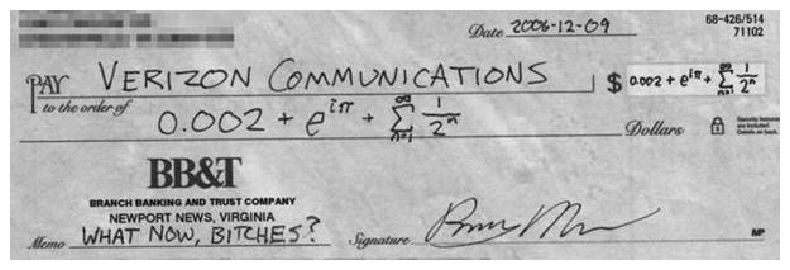

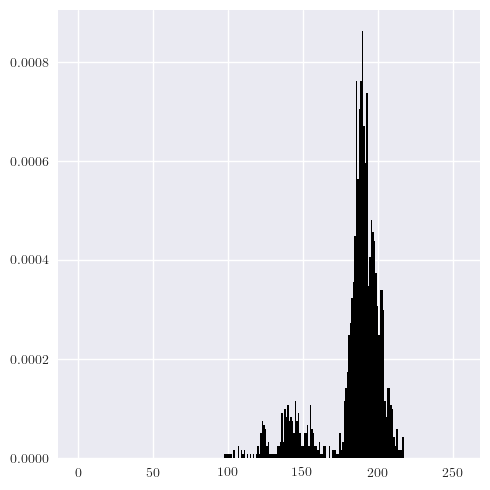

In [26]:
cheq = cv.imread('grayscale_check.jpg')
hist = np.zeros(256)
for i in range(cheq.shape[-1]):
    hist += np.squeeze(cv.calcHist(cheq, [i], None, [256], [0, 255]))
hist /= cheq.size

mp.imshow(cheq, 'gray')
mp.axis('off')
mp.tight_layout()
mp.show()

mp.figure(figsize=(5, 5))
mp.bar(range(256), hist, color='k', width=1.0)
mp.tight_layout()
mp.show()

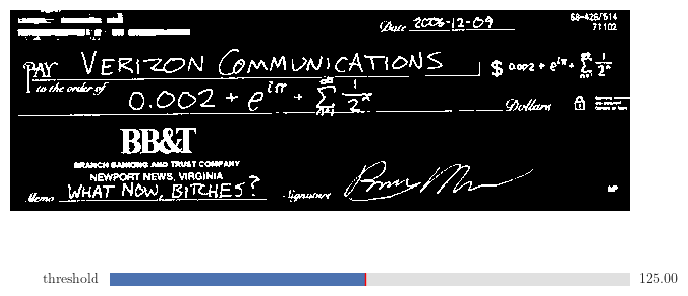

In [27]:
cgray = cv.cvtColor(cheq, cv.COLOR_BGR2GRAY)

fig, ax = mp.subplots()
mp.subplots_adjust(bottom=0.1)
ax.axis('off')
ax.grid(0)
Int = np.arange(256)
I0 = 125
delta_I = 1
BW = cgray < I0
im = mp.imshow(BW, 'gray')
ax.margins(x=0)

axthres = mp.axes([0.25, 0.1, 0.65, 0.03], facecolor='#e0e0e0')
sthres = widgets.Slider(axthres, 'threshold', 0, 255, valinit=I0, valstep=delta_I)

def update(val):
    thres = sthres.val
    im.set_array(cgray < thres)
    fig.canvas.draw_idle()
    
sthres.on_changed(update)

# mp.tight_layout()
mp.show()

In [52]:
class ImageSegment:
    
    def __init__(self, image):
        if type(image) == str:
            self.image = cv.imread(image)
        elif type(image) == np.ndarray:
            self.image = image
        else:
            raise NotImplementedError
        self.cropping = False
        self.sel_rect_endpoint = None
        self.refpt = None
        
    def BGR2NCC(self, img):
        I = img.sum(axis=2)
        r = img[:,:,2]/I
        g = img[:,:,1]/I
        return I, r, g

    def pixelLikelihood(self, r, mu, sigma):
        return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(r - mu)**2/(2 * sigma**2))
    
    def ColorPicker(self, event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            self.refpt = [(x, y)]
            self.cropping = True
            
        elif event == cv.EVENT_LBUTTONUP:
            self.refpt.append((x, y))
            self.cropping = False

            cv.rectangle(self.image, self.refpt[0], self.refpt[1], (0, 255, 0), 2)
            cv.imshow('macbeth', self.image)
            
        elif event == cv.EVENT_MOUSEMOVE and self.cropping:
            self.sel_rect_endpoint = [(x, y)]
            
    def get_ROI(self):
        image = self.image.astype('float32')/self.image.max()
        clone = image.copy()
        cv.namedWindow('macbeth')
        cv.setMouseCallback('macbeth', self.ColorPicker)

        while True:
            if not self.cropping:
                cv.imshow('macbeth', self.image)
            elif self.cropping and self.sel_rect_endpoint:
                rect_cpy = image.copy()
                cv.rectangle(rect_cpy, self.refpt[0], self.sel_rect_endpoint[0], (0, 255, 0), 1)
                cv.imshow('macbeth', rect_cpy)
            
            key = cv.waitKey(1) & 0xFF
            if key == ord('r'):
                image = clone.copy()

            elif key == ord('c'):
                break

        if len(self.refpt) == 2:
            self.roi = clone[self.refpt[0][1]:self.refpt[1][1], self.refpt[0][0]:self.refpt[1][0]]
            cv.imshow("ROI", self.roi)
            cv.waitKey(0)

        cv.destroyAllWindows()
    
    def get_chromaROI(self):
        I, r, g = self.BGR2NCC(self.roi)
        self.mu_r, self.sigma_r = np.mean(r), np.std(r)
        self.mu_g, self.sigma_g = np.mean(g), np.std(g)
        self.roi_I, self.roi_r, self.roi_g = I, r, g
        
    def get_chromaIMG(self):
        image = self.image.astype('float32')/self.image.max()
        I, r, g = self.BGR2NCC(image)
        pr = self.pixelLikelihood(r, self.mu_r, self.sigma_r)
        pg = self.pixelLikelihood(g, self.mu_g, self.sigma_g)
        self.combinedHist = pr * pg
        self.img_I, self.img_r, self.img_g = I, r, g
        
    def get_histROI(self, bins=256):
        image = self.roi
        if str(image.dtype) is not 'uint8':
            image = (image/image.max() * 255).astype('uint8')
        histROI = cv.calcHist([image], [0, 1], None, [bins, bins], [0, bins-1, 0, bins-1])/image.size
        histROI = (histROI/histROI.max() * 255).astype('uint8')
        self.histROI = histROI
        
    def get_histIMG(self, bins=256):
        image = self.image
        if str(image.dtype) is not 'uint8':
            image = (image/image.max() * 255).astype('uint8')
        histIMG = cv.calcHist([image], [0, 1], None, [bins, bins], [0, bins-1, 0, bins-1])/image.size
        histIMG = (histIMG/histIMG.max() * 255).astype('uint8')
        self.histIMG = histIMG
        
    def backproject(self):
        self.combinedHist = np.zeros_like(self.histIMG)
        for i in range(self.combinedHist.size):
            self.combinedHist.flat[i] = 
    
    def plot_segment(self):
        fig = mp.figure(figsize=(16, 9))
        
        ax = fig.add_subplot(121)
        ax.imshow(self.image[:,:,::-1])
        ax.axis('off')
        ax.grid(0)
        
        ax = fig.add_subplot(122)
        ax.imshow(self.combinedHist, 'gray')
        ax.axis('off')
        ax.grid(0)
        
        mp.show()
        
    def parametric(self):
        self.get_ROI()
        self.get_chromaROI()
        self.get_chromaIMG()
        self.plot_segment()
        
    def nonparametric(self):
        self.get_ROI()
        self.get_histROI()
        self.get_histIMG()
        self.backproject()
        self.plot_segment()

In [53]:
seg = ImageSegment('Macbeth_ColorChecker.jpg')
seg.nonparametric()

TypeError: Invalid shape (256, 256, 256) for image data

1